## Climate data Assignment
Make a 12-panel plot of the climatology (1 panel for each month) of your data. If your data is not at a time frequency that allows monthly climatology, either choose individual times or a different aggregation (seasonal? year?). Make the plot look publication quality with titles, units, labels, good colorbar, continents, etc.
To submit your assignment:
•Create a repository on github.com for your assignment
•Upload your Jupyter Notebook
•Create 1 issue
•Describe one way you would improve your figure. There is always something to improve, so think critically about  what you could do to make it more clear, nicer, better suited to a particular medium, etc
Send an email to me with a link to your repository.

In [2]:
#Import
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cart
import cartopy.io.img_tiles as cimgt
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import calendar

In [3]:
# Load the dataset
path = '/scratch/dveronez/dveronez/diana_assignment/'
file = 'data_precipitation.nc'

In [4]:
ds = xr.open_dataset(path+'/'+file)
ds

<xarray.Dataset> Size: 56MB
Dimensions:     (valid_time: 716, latitude: 121, longitude: 161)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2023-01-01 ... 2023-12-30T12:...
  * latitude    (latitude) float64 968B 50.0 49.75 49.5 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 1kB -100.0 -99.75 -99.5 ... -60.25 -60.0
    expver      (valid_time) <U4 11kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 56MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-16T18:37 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
# Resample and group the data
ds_monthly = ds.resample(valid_time='M').mean()
ds_month = ds.groupby('valid_time.month').mean()
ds_month

/home/dveronez/miniforge/envs/climate/lib/python3.12/site-packages/xarray/groupers.py:403: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<xarray.Dataset> Size: 937kB
Dimensions:    (month: 12, latitude: 121, longitude: 161)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 968B 50.0 49.75 49.5 49.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 1kB -100.0 -99.75 -99.5 ... -60.25 -60.0
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tp         (month, latitude, longitude) float32 935kB 1.325e-05 ... 4.561...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-16T18:37 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
max_precip = ds_month['tp'].max()
print(max_precip)

<xarray.DataArray 'tp' ()> Size: 4B
np.float32(0.00095021725)
Coordinates:
    number   int64 8B 0


In [7]:
min_precip = ds_month['tp'].min()
print(min_precip)

<xarray.DataArray 'tp' ()> Size: 4B
np.float32(0.0)
Coordinates:
    number   int64 8B 0


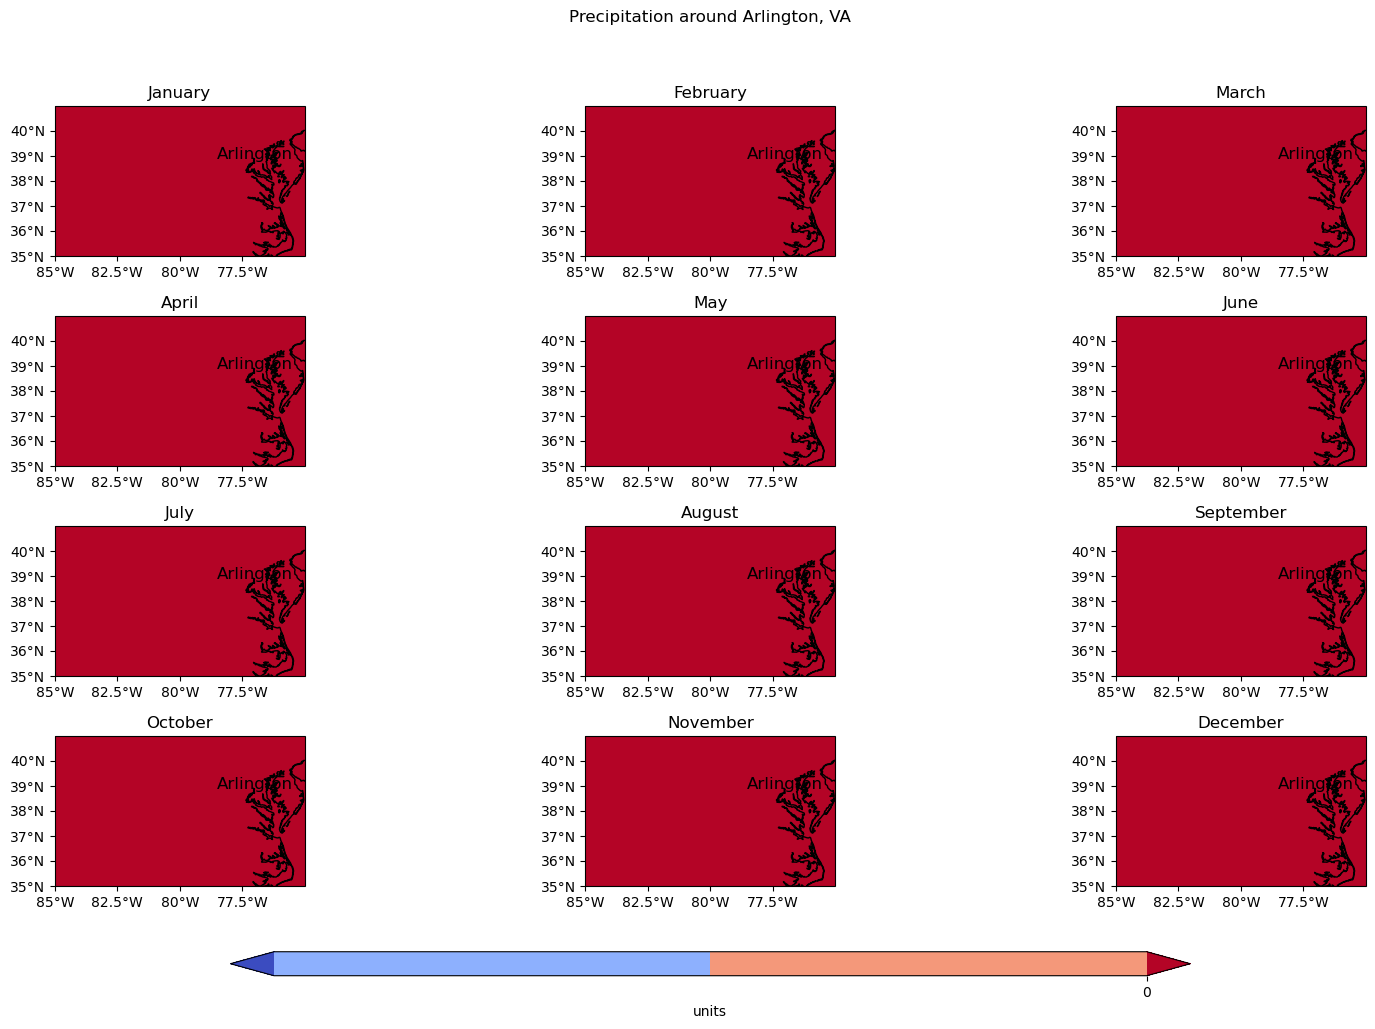

In [8]:
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4, ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16, 12))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs = axs.flatten()

# Adjust contour levels based on actual data range (assuming 0 to 0.00096)
clevs = np.arange(-1, 0.00096, 0.5)  # Adjusted levels

# Loop over all of the months and plot
for i, month in enumerate(ds_month['month']):

    # Select the month
    data = ds_month['tp'].sel(month=month)

    # Add the cyclic point
    data, lons = add_cyclic_point(data, coord=ds_month['longitude'])

    # Contour plot with adjusted temperature range
    cs = axs[i].contourf(lons, ds_month['latitude'], data, clevs,
                         transform=ccrs.PlateCarree(),
                         cmap='coolwarm', extend='both')

    # Longitude labels for the Arlington region
    axs[i].set_xticks(np.arange(-85, -75, 2.5), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels for the Arlington region
    axs[i].set_yticks(np.arange(35, 41, 1), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)

    # Title each subplot with the name of the month
    month_name = calendar.month_name[month.values]
    axs[i].set_title(month_name)

    # Draw the coastlines for each subplot
    axs[i].coastlines()

    # Set the extent to focus on Arlington, VA region 
    axs[i].set_extent([-85, -75, 35, 41], crs=ccrs.PlateCarree())

    # Add label "Arlington"
    axs[i].text(-77, 38.9, 'Arlington', horizontalalignment='center',
                transform=ccrs.PlateCarree(), fontsize=12, color='black')

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.4, hspace=0.4)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Add a colorbar with adjusted temperature ticks
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal',
                    label='units', ticks=np.arange(0, 0.00096, 2))  # Adjusted range

# Add a big title at the top
plt.suptitle('Precipitation around Arlington, VA')

plt.show()

In [ ]:
# change np.arange to np.linspace to improve the plots.

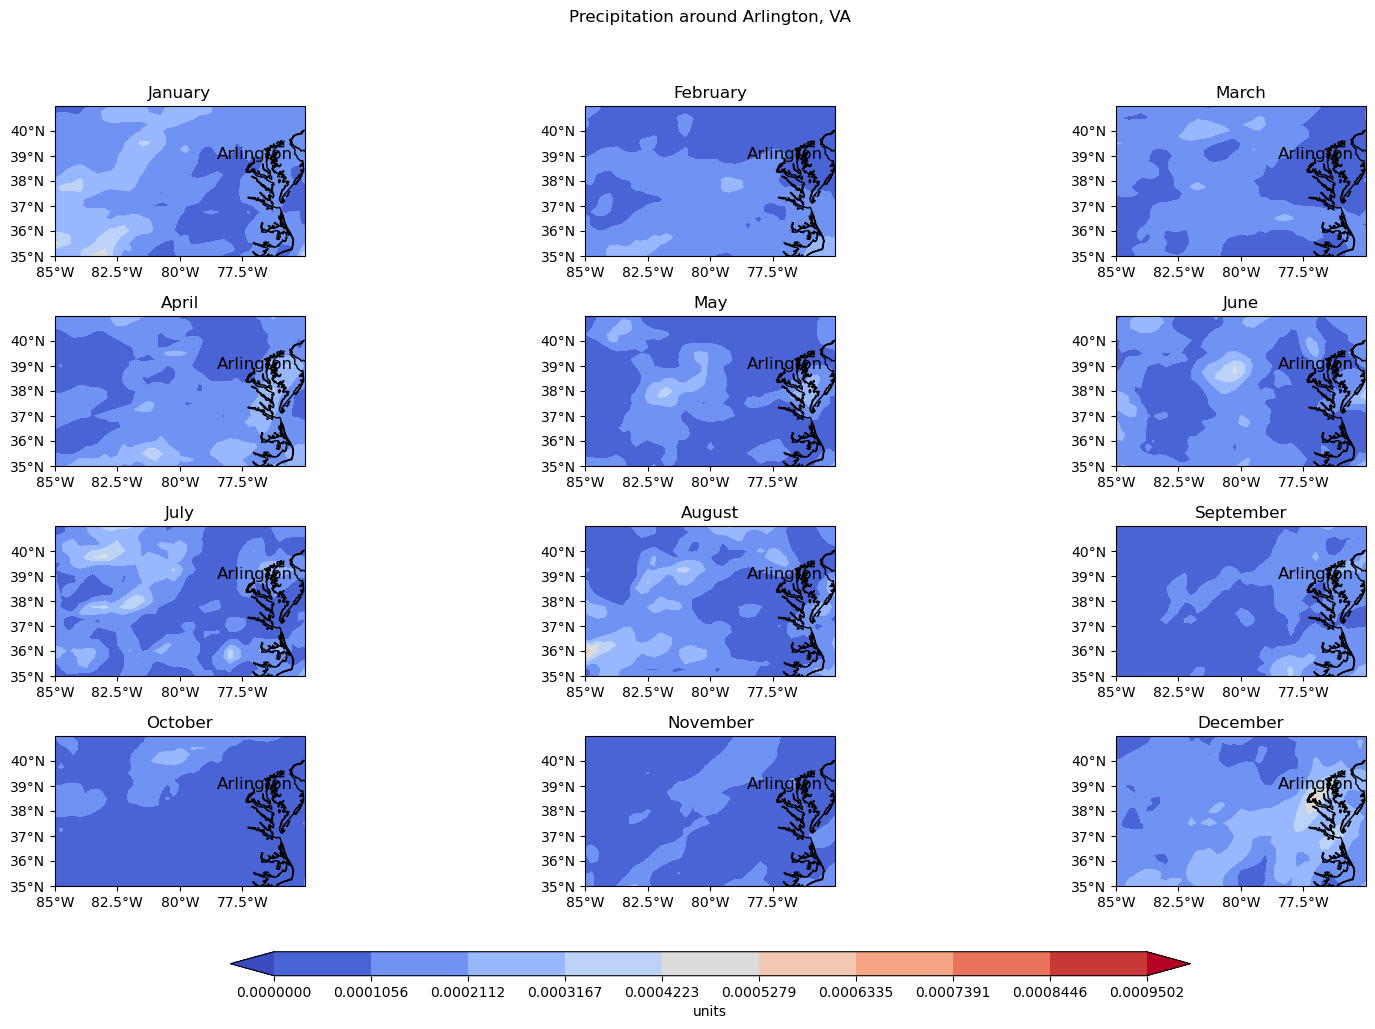

In [10]:
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4, ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16, 12))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs = axs.flatten()

# Adjust contour levels based on actual data range (min_precip to max_precip)
clevs = np.linspace(min_precip, max_precip, 10)

# Loop over all of the months and plot
for i, month in enumerate(ds_month['month']):

    # Select the month
    data = ds_month['tp'].sel(month=month)

    # Add the cyclic point
    data, lons = add_cyclic_point(data, coord=ds_month['longitude'])

    # Contour plot with adjusted temperature range
    cs = axs[i].contourf(lons, ds_month['latitude'], data, clevs,
                         transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')

    # Longitude labels for the Arlington region
    axs[i].set_xticks(np.arange(-85, -75, 2.5), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels for the Arlington region
    axs[i].set_yticks(np.arange(35, 41, 1), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)

    # Title each subplot with the name of the month
    month_name = calendar.month_name[month.values]
    axs[i].set_title(month_name)

    # Draw the coastlines for each subplot
    axs[i].coastlines()

    # Set the extent to focus on Arlington, VA region 
    axs[i].set_extent([-85, -75, 35, 41], crs=ccrs.PlateCarree())

    # Add label "Arlington"
    axs[i].text(-77, 38.9, 'Arlington', horizontalalignment='center',
                transform=ccrs.PlateCarree(), fontsize=12, color='black')

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.4, hspace=0.4)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Add a colorbar with adjusted temperature ticks
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal',
                    label='units', ticks=np.linspace(min_precip, max_precip, 10))

# Add a big title at the top
plt.suptitle('Precipitation around Arlington, VA')

plt.show()
